# <center> <u>**Création du dataset de classification** </u></center>



# Caractéristiques du dataset :

* Provenance des images : 

    * Anthophila
    * HS 
    * Justine
    * LMDI 
    * Spipoll
    * DG (uniquement pour le test)
    * inaturalist_2305 (monde) 


* Les images ont déjà été détectées par Yolo

* En ce qui concerne inaturalist,on a vu que les images pouvaient être similiaires. L'idéal est de filtrer les doublons, ici on va simplement cantonner les photos inat au train.




# 1. Sélection des photos dans le dossier 'whole_dataset'

Juste pour avoir un ordre de grandeur

In [43]:
! echo "Nombre total d'images avant détection :  "
! find '../../data_bees_detection/whole_dataset/' -type f | wc -l


Nombre total d'images avant détection :  
247415


In [44]:
! echo "Dont inaturalist :  "
! find  '../../data_bees_detection/whole_dataset/inaturalist_2305/' -type f | wc -l

Dont inaturalist :  
178410


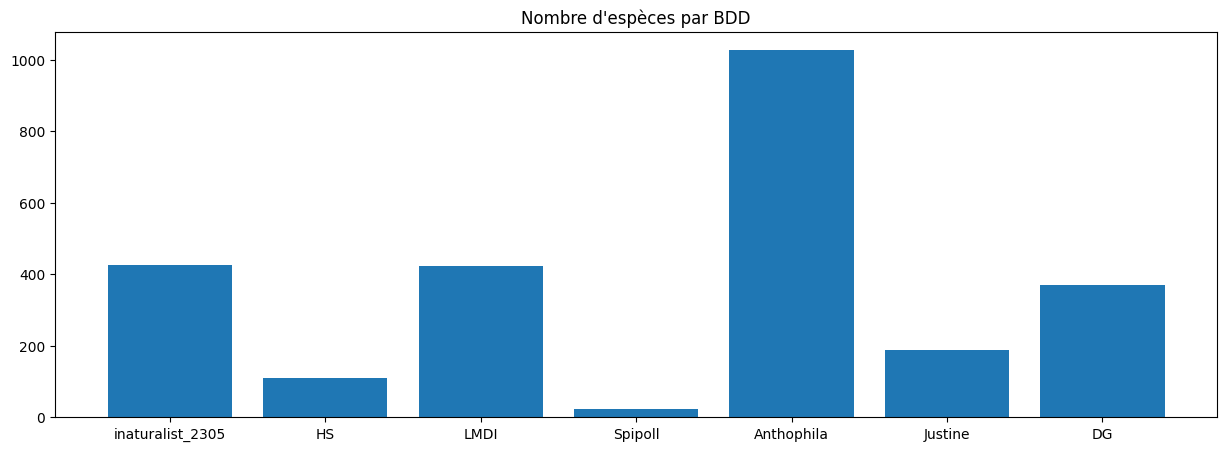

In [45]:
from matplotlib import pyplot as plt
import os

# histogramme du nombre d'images par dossier 

path = '../../data_bees_detection/whole_dataset/'
folders = os.listdir(path)
folders_path = [path + folder for folder in folders]

nb_esp = {}

for folder in folders_path:
    nb_esp[folder] = len(os.listdir(folder))

# plot
plt.figure(figsize=(15,5))
plt.bar(range(len(nb_esp)), list(nb_esp.values()), align='center')
plt.xticks(range(len(nb_esp)), folders)
plt.title('Nombre d\'espèces par BDD')
plt.show()


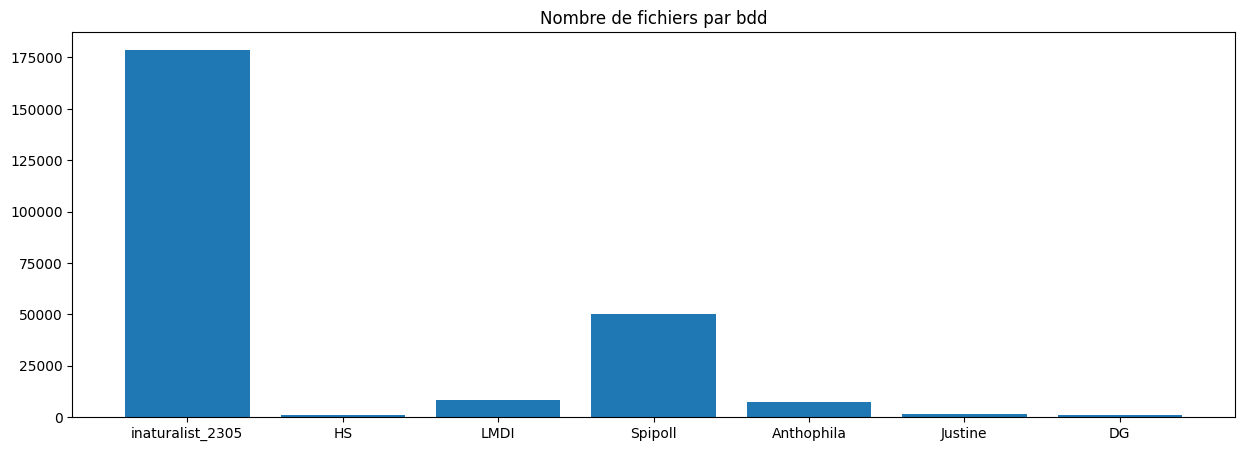

In [46]:
import subprocess as sp

nb_imgs = {}

for folder in folders_path:
    
    cmd = 'find ' + folder + ' -type f | wc -l'
    nb_img = sp.getoutput(cmd)

    folder_name = folder.split('/')[-1]

    nb_imgs[folder_name] = int(nb_img)

# plot
plt.figure(figsize=(15,5))
plt.bar(range(len(nb_imgs)),list(nb_imgs.values()))
plt.xticks(range(len(nb_imgs)),list(nb_imgs.keys()))
plt.title('Nombre de fichiers par bdd')
plt.show()


Edition d'un csv sur lequel travailler

In [47]:

! rm '../datafiles/classification/datasets/0713_classification_paths.csv'
! find '../../data_bees_detection/whole_dataset/' -type f >> '../datafiles/classification/datasets/0713_classification_paths.csv'


In [48]:
import pandas as pd 

df = pd.read_csv('../datafiles/classification/datasets/0713_classification_paths.csv',encoding_errors='ignore',sep=';',header=None)
df.columns = ['paths']

df['extensions'] = df['paths'].apply(lambda x : x.split('.')[-1])


df.describe()

,paths,extensions
count,247415,247415
unique,247415,31
top,../../data_bees_detection/whole_dataset/inatur...,jpg
freq,1,145917


## 1.1 On ne garde que les images

In [49]:
df['extensions'].unique()

array(['jpg', 'jpeg', 'png', 'JPG', 'gif', 'tmp', 'csv', 'zip', 'txt',
       'CR2', 'mp4', '_et_f_', '_chrysurus_female',
       '_Andrena_Lepiandrena_pandellei_male', '_pollinosa_female',
       '_I_leave', '_Alain_Pauly_!!!', '_clypeare_female',
       '_terrestris_female', '_decolorated', '_argentata_dorsalis_female',
       '_Andrena_Melandrena_nitida_female',
       '_Andrena_Melandrena_nitida_male', '_aestivalis_female', '_et_f',
       '_fulviventris', '_Nest_and_female', '_montanus',
       '_montanus_female_with_their_typicals_radials_cells',
       '_argentata_female', '_nuptialis_female'], dtype=object)

In [50]:
img_allow_list = ['jpg','jpeg','png','JPG']

df_wrong_ext = df[~df['extensions'] .isin(img_allow_list)]

df = df[df['extensions'] .isin(img_allow_list)]

df_wrong_ext.describe()

,paths,extensions
count,185,185
unique,185,27
top,../../data_bees_detection/whole_dataset/inatur...,csv
freq,1,87


In [51]:
df.describe()

,paths,extensions
count,247230,247230
unique,247230,4
top,../../data_bees_detection/whole_dataset/inatur...,jpg
freq,1,145917


## 1.2 On ne garde que les images labelisées au niveau de l'espèce

Est considéré comme un label 'espèce' un label qui : 

* Contient plus d'un mot (pas Bombus / Apis)
* Ne contient pas " sp" --> species affinis (sauf pour Osmia spinusola)

In [52]:
def is_specie(x): 

    if len(x.split(' ')) == 1: 

        return False
    
    

    elif x == 'Osmia spinulosa':
            
        return True
    
    elif ' sp' in x :

        return False
    
    else :

        return True
    

print('Bombus : {}'.format(is_specie('Bombus')))
print('Bombus sp: {}'.format(is_specie('Bombus terrestris sp')))
print('Bombus terrestris: {}'.format(is_specie('Bombus terrestris')))

Bombus : False
Bombus sp: False
Bombus terrestris: True


In [53]:
df['label'] = df['paths'].apply(lambda x : x.split('/')[-2])
df['is_specie'] = df['label'].apply(lambda x : is_specie(x))

df_not_label = df[df['is_specie']==False]
df = df[df['is_specie']==True] 

In [54]:
df_not_label.describe()

,paths,extensions,label,is_specie
count,30999,30999,30999,30999
unique,30999,4,52,1
top,../../data_bees_detection/whole_dataset/HS/Ame...,jpg,Bombus,False
freq,1,30265,21245,30999


In [55]:
df.describe()

,paths,extensions,label,is_specie
count,216231,216231,216231,216231
unique,216231,4,650,1
top,../../data_bees_detection/whole_dataset/inatur...,jpg,Apis mellifera,True
freq,1,115652,19798,216231


## 1.3 Edition de csv récapitulatifs

In [56]:
df['bdd'] = df['paths'].apply(lambda x : x.split('/')[-3]).astype(str)

bdds = df['bdd'].unique().tolist()

df.drop(['is_specie','extensions'],axis=1,inplace=True)





In [57]:
df.describe()

,paths,label,bdd
count,216231,216231,216231
unique,216231,650,7
top,../../data_bees_detection/whole_dataset/inatur...,Apis mellifera,inaturalist_2305
freq,1,19798,178391


In [58]:
# # cap number of pictures per label to 1000

# Group the dataframe by the '#label' column
grouped = df.groupby('label')

# # Create an empty list to store the filtered data
# filtered_data = []

# # Iterate over each group
# for label, group in grouped:
#     if len(group) >= 1000:
#         # If the group has 1000 or more paths, add only 1000 paths
#         filtered_data.append(group.sample(1000))
        
#     else:
#         # If the group has fewer than 1000 paths, add all of them
#         filtered_data.append(group)

# # Concatenate the filtered data into a new dataframe
# df_filtered = pd.concat(filtered_data)

# # Reset the index of the filtered dataframe
# df_filtered = df_filtered.reset_index(drop=True)


grouped["paths"].count().describe()

count      650.000000
mean       332.663077
std       1489.406499
min          1.000000
25%          5.000000
50%         25.000000
75%        109.750000
max      19798.000000
Name: paths, dtype: float64

In [59]:
df['label'].value_counts().describe()


count      650.000000
mean       332.663077
std       1489.406499
min          1.000000
25%          5.000000
50%         25.000000
75%        109.750000
max      19798.000000
Name: count, dtype: float64

In [60]:
# count number of image per specie per bdd 
df_count = df.groupby(['bdd','label']).count().reset_index()

# set default value to 0 and dtype to int
df_count['paths'] = df_count['paths'].astype('int')

# put bdd as columns
df_count = df_count.pivot(index='label',columns='bdd',values='paths').reset_index()

df_count['total'] = df_count.iloc[:,1:].sum(axis=1) 

total_count = df_count.sort_values(by='total',ascending=False).copy()


# STATS

In [61]:
df_count.sort_values('total',ascending=False).to_csv('../datafiles/classification/datasets/0713_nb_photos_espèces_bdd.csv')

In [41]:

# filter df to keep only species with more than 50 images
labels_to_keep = df_count[df_count['total'] > 50]['label']

df = df[df['label'].isin(labels_to_keep)]


In [42]:
df.describe()

,paths,label,bdd
count,421046,421046,421046
unique,210523,237,7
top,../../data_bees_detection/whole_dataset/inatur...,Apis mellifera,inaturalist_2305
freq,2,39596,351584


Pour chaque espèce avec plus de 50 photos, on ne garde que 1000 photos

In [18]:
# remove extra photos of labels with more than 1000 images
# following this order : DG,HS,Justine,Anthophila,LMDI,Spipoll,inaturalist_2305_france

labels_to_filter =  df_count[df_count['total'] > 1000]['label']

hierarchy = ['DG','HS','Justine','Anthophila','LMDI','Spipoll','inaturalist_2305_france']

# Create a categorical data type with the desired order
cat_dtype = pd.CategoricalDtype(categories=hierarchy, ordered=True)

# Convert the 'bdd' column to the categorical data type
df['bdd'] = df['bdd'].astype(cat_dtype)

# Sort the DataFrame by the 'bdd' column
df_sorted = df.sort_values('bdd')
li = []

for label in labels_to_filter: 

    temp_df = df[df['label']==label]
    temp_df.sort_values('bdd')
    li.append(temp_df.iloc[:1000,:])

df = pd.concat(li)

/tmp/ipykernel_536/2772497528.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdd'] = df['bdd'].astype(cat_dtype)


In [19]:
df

,paths,label,bdd
169680,../../data_bees_detection/whole_dataset/inatur...,Andrena cineraria,NaN
169681,../../data_bees_detection/whole_dataset/inatur...,Andrena cineraria,NaN
169682,../../data_bees_detection/whole_dataset/inatur...,Andrena cineraria,NaN
169683,../../data_bees_detection/whole_dataset/inatur...,Andrena cineraria,NaN
169684,../../data_bees_detection/whole_dataset/inatur...,Andrena cineraria,NaN
...,...,...,...
80993,../../data_bees_detection/whole_dataset/inatur...,Xylocopa violacea,NaN
80994,../../data_bees_detection/whole_dataset/inatur...,Xylocopa violacea,NaN
80995,../../data_bees_detection/whole_dataset/inatur...,Xylocopa violacea,NaN
80996,../../data_bees_detection/whole_dataset/inatur...,Xylocopa violacea,NaN


In [20]:
#df_count.to_csv('../datafiles/classification/0710_classification_count.csv',sep=';',index=False)
df.to_csv('../datafiles/classification/0713_classification_no_species.csv',sep=';',index=False)

# 2. Récupération des prédictions faites par YOLO sur ces photos

## 2.1 Mise en forme du csv de prédictions

In [62]:
yolo_predictions = '/datafiles/crop/predictions_whole_dataset_cleaned_only_species_50_1000.csv'

df_yolo = pd.read_csv(yolo_predictions,sep=',')

def true_path(x):

    list_path = x.split('/')[3:]
    path = '/'.join(list_path)
    path = '../../' + path
    return path

df_yolo['path'] = df_yolo['path'].apply(lambda x : true_path(x))

df_yolo.head()

,path,xmin,ymin,xmax,ymax,label,img_w,img_h
0,../../data_bees_detection/whole_dataset_cleane...,83,90,378,303,Anthophila,500,333
1,../../data_bees_detection/whole_dataset_cleane...,65,42,401,304,Anthophila,500,375
2,../../data_bees_detection/whole_dataset_cleane...,75,56,447,275,Anthophila,500,333
3,../../data_bees_detection/whole_dataset_cleane...,92,112,364,276,Anthophila,500,375
4,../../data_bees_detection/whole_dataset_cleane...,61,59,400,202,Anthophila,500,278


On récupère la bdd de provenance des images

In [63]:
bdds = ['LMDI','Spipoll','HS','inat_25_04','iNaturalist','Anthophila','Justine','DG']

def find_bdd(x):
        
    for bdd in bdds:
        
        if bdd in x:

            if 'inat_25_04' in x: 

                return 'inaturalist_2305','inat_25_04'

            elif 'iNaturalist' in x:

                return 'inaturalist_2205','iNaturalist'

            else :

                return str(bdd),str(bdd)

def find_path(x):

    bdd,old_bdd_name = find_bdd(x)

    old_bdd_name = old_bdd_name + '_'

    img_name = x.split('/')[-1]

    img_name = img_name.replace(old_bdd_name,'')

    label = x.split('/')[-2]

    return '../../data_bees_detection/whole_dataset/' + bdd + '/' + label + '/'+ str(img_name)

print(df_yolo['path'][0])
find_path(df_yolo['path'][0])

../../data_bees_detection/whole_dataset_cleaned/Andrena tibialis/inat_25_04_68829767.jpeg


'../../data_bees_detection/whole_dataset/inaturalist_2305/Andrena tibialis/68829767.jpeg'

In [64]:
df_yolo['new_path'] = df_yolo['path'].apply(lambda x: find_path(x))

df_yolo.head()

,path,xmin,ymin,xmax,ymax,label,img_w,img_h,new_path
0,../../data_bees_detection/whole_dataset_cleane...,83,90,378,303,Anthophila,500,333,../../data_bees_detection/whole_dataset/inatur...
1,../../data_bees_detection/whole_dataset_cleane...,65,42,401,304,Anthophila,500,375,../../data_bees_detection/whole_dataset/inatur...
2,../../data_bees_detection/whole_dataset_cleane...,75,56,447,275,Anthophila,500,333,../../data_bees_detection/whole_dataset/inatur...
3,../../data_bees_detection/whole_dataset_cleane...,92,112,364,276,Anthophila,500,375,../../data_bees_detection/whole_dataset/inatur...
4,../../data_bees_detection/whole_dataset_cleane...,61,59,400,202,Anthophila,500,278,../../data_bees_detection/whole_dataset/inatur...


Vérification que le new path existe

In [65]:
import os

df_yolo['exists'] = df_yolo['new_path'].apply(lambda x : os.path.exists(x))

df_yolo['exists'].mean()

0.7972889456553088

**Tout est bien lisible !**

In [66]:
df_yolo.to_csv('../datafiles/crop/0710_predictions_whole_dataset_cleaned_with_key_to_whole_dataset.csv')

## 2.2 Jointure entre les dataframes 

In [8]:
df_dataset = pd.read_csv('../datafiles/classification/0710_classification_paths_no_species.csv', encoding_errors = 'ignore',sep =';')
df_dataset.columns = ['paths','label','bdd']
df_yolo = pd.read_csv('../datafiles/crop/0710_predictions_whole_dataset_cleaned_with_key_to_whole_dataset.csv')

df_merged = df_dataset.merge(df_yolo,how='left',left_on=['paths'],right_on=['new_path'])

print(df_dataset.shape)

print(df_merged.shape)

(216231, 3)
(221059, 14)


In [9]:
df_missing = df_dataset[~df_dataset['paths'].isin(df_merged['paths'])]
df_missing.shape

(0, 3)

La jointure est bonne, la différence entre df_dataset et df_pred est due aux images où plusieurs specimens ont été détectés.

In [10]:
df_merged.head()

,paths,label_x,bdd,Unnamed: 0,path,xmin,ymin,xmax,ymax,label_y,img_w,img_h,new_path,exists
0,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,73482.0,../../data_bees_detection/whole_dataset_cleane...,78.0,2.0,430.0,323.0,Anthophila,500.0,334.0,../../data_bees_detection/whole_dataset/inatur...,True
1,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,73433.0,../../data_bees_detection/whole_dataset_cleane...,96.0,73.0,203.0,166.0,Anthophila,287.0,267.0,../../data_bees_detection/whole_dataset/inatur...,True
2,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,73466.0,../../data_bees_detection/whole_dataset_cleane...,29.0,106.0,226.0,385.0,Anthophila,281.0,500.0,../../data_bees_detection/whole_dataset/inatur...,True
3,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,73303.0,../../data_bees_detection/whole_dataset_cleane...,175.0,92.0,428.0,358.0,Anthophila,500.0,470.0,../../data_bees_detection/whole_dataset/inatur...,True
4,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,73514.0,../../data_bees_detection/whole_dataset_cleane...,270.0,-14.0,507.0,213.0,Anthophila,500.0,281.0,../../data_bees_detection/whole_dataset/inatur...,True


In [11]:
df_merged.drop(['new_path','exists','path','label_y','Unnamed: 0'],axis=1,inplace=True)


df_merged.columns = ['paths','label','bdd','x_min','y_min','x_max','y_max','width','height']

df_merged.head()

,paths,label,bdd,x_min,y_min,x_max,y_max,width,height
0,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,78.0,2.0,430.0,323.0,500.0,334.0
1,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,96.0,73.0,203.0,166.0,287.0,267.0
2,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,29.0,106.0,226.0,385.0,281.0,500.0
3,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,175.0,92.0,428.0,358.0,500.0,470.0
4,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,270.0,-14.0,507.0,213.0,500.0,281.0


In [12]:
df_merged.to_csv('../datafiles/classification/0710_dataset_for_classification_with_yolo_pred.csv',index=False)

## 2.3 (optionnel si crop à la volée : Jointure entre le dataset et le dossier d'images cropées)

On a préalablement créé un dossier avec les images cropées par YOLO, on récupère le chemin de ces images et on les ajoute au dataframe

In [94]:
import pandas as pd 
import os 

df_merged = pd.read_csv('../datafiles/classification/0710_dataset_for_classification_with_yolo_pred.csv')

df_merged['paths'][0]

'../../data_bees_detection/whole_dataset/inaturalist_2305/Hylaeus hyalinatus/132248441.jpg'

In [100]:
! rm '../datafiles/crop/0710_whole_dataset_cropped_paths.csv'
! find '../../data_bees_detection/cropped_dataset/' -type f >> '../datafiles/crop/0710_whole_dataset_cropped_paths.csv'

In [101]:
df_cropped = pd.read_csv('../datafiles/crop/0710_whole_dataset_cropped_paths.csv',header=None)
df_cropped.columns = ['paths']

df_cropped["paths"][22109]

'../../data_bees_detection/cropped_dataset/whole_dataset_cropped_with_cleaned_structure/Andrena flavipes/whole_dataset_cropped_inat_25_04_inat_8_Andrena flavipes_81783038.jpg'

Le but est ici aussi de récupérer le chemin dans whole_dataset pour pouvoir faire la jointure

(ici on fait path_cropped to path_whole_dataset, à cause de 'inat_25_04/inat_4' ce n'est pas bijectif)

In [102]:
bdds = ['LMDI','Spipoll','HS','inat_25_04','iNaturalist','Anthophila','Justine','DG']

def find_bdd(x):
        
    for bdd in bdds:
        
        if bdd in x:

            if 'inat_25_04' in x: 

                return 'inaturalist_2305','inat_25_04'

            elif 'iNaturalist' in x:

                return 'inaturalist_2205','iNaturalist'

            else :

                return str(bdd),str(bdd)

def find_path(x):

    bdd,old_bdd_name = find_bdd(x)

    old_bdd_name = old_bdd_name + '_'

    img_name = x.split('/')[-1]

    label = x.split('/')[-2]

    img_name = img_name.split(label)[-1].replace('_','')


    return '../../data_bees_detection/whole_dataset/' + bdd + '/' + label + '/'+ str(img_name)

print(df_cropped['paths'][0])
find_path(df_cropped['paths'][0])

../../data_bees_detection/cropped_dataset/whole_dataset_cropped_with_cleaned_structure/Hylaeus hyalinatus/whole_dataset_cropped_inat_25_04_inat_3_Hylaeus hyalinatus_207755263.jpg


'../../data_bees_detection/whole_dataset/inaturalist_2305/Hylaeus hyalinatus/207755263.jpg'

In [103]:
df_cropped['path_whole_dataset'] = df_cropped['paths'].apply(lambda x: find_path(x)).astype('str')    

df_dataset_cropped_paths = df_merged.merge(df_cropped,how='left',left_on=['paths'],right_on=['path_whole_dataset'])

df_dataset_cropped_paths.drop(['bdd','x_min','y_min','x_max','y_max','width','height','path_whole_dataset'],axis=1,inplace=True)

df_dataset_cropped_paths.columns = ['paths','label','path_cropped']

df_dataset_cropped_paths = df_dataset_cropped_paths.astype(str) 


df_dataset_cropped_paths['exists'] = df_dataset_cropped_paths['path_cropped'].apply(lambda x : os.path.exists(x))

df_dataset_cropped_paths['exists'].mean()

0.8524739371152172

In [105]:
to_crop = df_dataset_cropped_paths[df_dataset_cropped_paths['exists']==False].to_csv('../datafiles/crop/0710_to_crop.csv')

Problème : certaines photos sont manquantes

# 3. Vision générale du dataset 

In [8]:
import pandas as pd


df_dataset = pd.read_csv('../datafiles/classification/0710_dataset_for_classification.csv', encoding_errors = 'ignore')

df_dataset.head()

,paths,label,bdd,x_min,y_min,x_max,y_max,width,height
0,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,78.0,2.0,430.0,323.0,500.0,334.0
1,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,96.0,73.0,203.0,166.0,287.0,267.0
2,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,29.0,106.0,226.0,385.0,281.0,500.0
3,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,175.0,92.0,428.0,358.0,500.0,470.0
4,../../data_bees_detection/whole_dataset/inatur...,Hylaeus hyalinatus,inaturalist_2305,270.0,-14.0,507.0,213.0,500.0,281.0


In [9]:
# count number of image per specie per bdd
df_count = df_dataset.groupby(['bdd','label']).count().reset_index()

# set default value to 0 and dtype to int
df_count['paths'] = df_count['paths'].astype('int')

# put bdd as columns
df_count = df_count.pivot(index='label',columns='bdd',values='paths').reset_index()

df_count['total'] = df_count.iloc[:,1:].sum(axis=1)


df_count= df_count.sort_values(by='total',ascending=False)

df_count

bdd,label,Anthophila,DG,HS,Justine,LMDI,Spipoll,inaturalist_2305,total
185,Apis mellifera,9.0,1.0,NaN,NaN,55.0,19750.0,NaN,19815.0
242,Bombus terrestris,36.0,9.0,1.0,11.0,41.0,NaN,16048.0,16146.0
150,Anthidium manicatum,76.0,1.0,NaN,27.0,57.0,NaN,14875.0,15036.0
211,Bombus lapidarius,10.0,3.0,4.0,3.0,74.0,NaN,11358.0,11452.0
207,Bombus hypnorum,20.0,5.0,NaN,3.0,36.0,NaN,10920.0,10984.0
...,...,...,...,...,...,...,...,...,...
327,Eucera hispaliensis,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
41,Andrena distinguenda,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
43,Andrena erythrocnemis,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
44,Andrena espanola,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0


In [12]:
# group by total number of images per specie
df_count['total'].value_counts()

# keep only species with more than 50 images
df_count = df_count[df_count['total']>=50]

df_count.describe()


bdd,Anthophila,DG,HS,Justine,LMDI,Spipoll,inaturalist_2305,total
count,195.000000,172.000000,48.000000,143.000000,209.00000,11.000000,234.000000,245.000000
mean,33.943590,2.697674,7.770833,8.188811,26.76555,1988.545455,767.666667,880.526531
std,36.654586,2.038058,10.196452,11.762887,21.24078,5897.729569,2018.205133,2343.813008
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,50.000000
25%,10.000000,1.000000,2.000000,2.500000,12.00000,9.000000,59.000000,88.000000
50%,23.000000,2.000000,3.000000,5.000000,21.00000,55.000000,125.000000,189.000000
75%,45.500000,3.000000,8.250000,10.000000,38.00000,433.500000,409.500000,495.000000
max,235.000000,16.000000,50.000000,117.000000,159.00000,19750.000000,16048.000000,19815.000000


# 4. Divisier en ensemble train test val 

On suivra la répartition suivante 80/10/10.

En outre, on établit la hiérarchie suivante entre les bases de données :

- inaturalist < Spipoll < LMDI < Anthophila < Justine < HS < DG

En faisant en sorte 

In [ ]:
from sklearn.model_selection import train_test_split


df_dataset

X_train, X_test, y_train, y_test = train_test_split(df_cropped[['path','xmin','ymin','xmax','ymax','img_w','img_h']],df_cropped['real_label'], test_size=0.2, random_state=42,stratify=df_cropped['real_label'])
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42,stratify=y_train)

# 5. Get hierarchy for hierarchical loss

In [ ]:
$ path_to_taxref = '../../data_bees_detection/TAXREF/TAXREF16.0_ALL__11_04_2023.csv'
$ path_to_dataset = '../datafiles/classification/0710_dataset_for_classification.csv'
$ path_to_output = '../datafiles/classification/'

! python3 get_hierarchy.py --path_taxref $path_to_taxref --path_whole_dataset_csv $path_to_dataset --path_output_csv $path_to_output'